In [8]:
from dotenv import load_dotenv
load_dotenv(".env", override=True)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Deepagent for Research

We will use the `deepagents` package to create a research agent. When using the `deepagents` package, it's important to: 

1. Understand the native tools available
2. Supply task-specific tools
3. Supply task-specific instructions
4. Supply task-specific sub-agents

## Task-Specific Tools 

You can see an overview of the native tools in the [deepagents package README](https://github.com/langchain-ai/deepagents?tab=readme-ov-file#model) as well as the [quickstarts README](https://github.com/langchain-ai/deepagents-quickstarts). We'll extend this with two task-specific tools. 

### Search Tool 

We'll supply a simple search tool that uses Tavily to search for relevant URLs, then fetches the full webpage content. 

### Think Tool 

We'll supply a [think tool](https://www.anthropic.com/engineering/claude-think-tool), which is a useful way to help audit agent decision making. 

In [9]:
from research_agent.tools import tavily_search, think_tool
tools = [tavily_search, think_tool]

## Task-Specific Instructions
 
Next, let's define task specific instructions using [a few prompting techniques for agents](https://youtu.be/XSZP9GhhuAc?si=zowpViL-2j-vI9hA):

### 1. Think Like The Agent
What instructions would you give a new work colleague?
- **Read the question carefully** - What specific information does the user need?
- **Start with broader searches** - Use broad, comprehensive queries first
- **After each search, pause and assess** - Do I have enough to answer? What's still missing?
- **Execute narrower searches as you gather information** - Fill in the gaps.

### 2. Concrete Heuristics (Prevent "Spin-Out" on excessive tool calls)
Use **Hard Limits** to prevent the research agent from calling tools excessively:
- **Stop when you can answer confidently** - Don't keep searching for perfection.
- **Give it budgets** - Use 2-3 search tool calls for simple queries. Use up to 5 for complex queries.
- **Limit** - Always stop after 5 search tool calls if you cannot find the right source(s).

### 3. Show your thinking
After each search tool calling, use [`think_tool` to analyze the results](https://www.anthropic.com/engineering/claude-think-tool):
- What key information did I find? 
- What's missing?
- Do I have enough to answer the question comprehensively?
- Should I search more or provide my answer?

In [10]:
from utils import show_prompt, format_messages
from research_agent.prompts import (
    RESEARCHER_INSTRUCTIONS,
    RESEARCH_WORKFLOW_INSTRUCTIONS,
    SUBAGENT_DELEGATION_INSTRUCTIONS,
)

In [11]:
show_prompt(RESEARCHER_INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research assistant conducting research on the user's input topic. For context, today's date is       │
│  {date}.                                                                                                        │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your job is to use tools to gather information about the user's input topic.                                   │
│  You can use any of the research tools provided to you to find resources that can help answer the research      │
│  question.                                                                                                      │
│  You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.          │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Research Tools>                                                                                     │
│  You have access to two specific research tools:                                                                │
│  1. **tavily_search**: For conducting web searches to gather information                                        │
│  2. **think_tool**: For reflection and strategic planning during research                                       │
│  **CRITICAL: Use think_tool after each search to reflect on results and plan next steps**                       │
│  </Available Research Tools>                                                                                    │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a human researcher with limited time. Follow these steps:                                           │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Start with broader searches** - Use broad, comprehensive queries first                                    │
│  3. **After each search, pause and assess** - Do I have enough to answer? What's still missing?                 │
│  4. **Execute narrower searches as you gather information** - Fill in the gaps                                  │
│  5. **Stop when you can answer confidently** - Don't keep searching for perfection                              │
│  </Instructions>                                                                                                │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Tool Call Budgets** (Prevent excessive searching):                                                           │
│  - **Simple queries**: Use 2-3 search tool calls maximum                                                        │
│  - **Complex queries**: Use up to 5 search tool calls maximum                                                   │
│  - **Always stop**: After 5 search tool calls if you cannot find the right sources                              │
│                                                       

## Task-Specific Sub-Agents

You can specify [custom subagents](https://github.com/langchain-ai/deepagents?tab=readme-ov-file#subagents) as a means of context isolation. 

Here's well define a sub-agent that can search the web for information. 

In [12]:
# Create research sub-agent
research_sub_agent = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "system_prompt": RESEARCHER_INSTRUCTIONS,
    "tools": [tavily_search, think_tool],
}

## Putting it all together

### Instructions

Now, we can look at all of our instructions together. 

In [13]:
INSTRUCTIONS = (
    RESEARCH_WORKFLOW_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + SUBAGENT_DELEGATION_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + RESEARCHER_INSTRUCTIONS
)

show_prompt(INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  # Research Workflow                                                                                            │
│                                                                                                                 │
│  Follow this workflow for all research requests:                                                                │
│                                                                                                                 │
│  1. **Save the request**: Use write_file() to save the user's research question to `/research_request.md`       │
│  2. **Plan**: Create a todo list with write_todos to break down the research into focused tasks                 │
│  3. **Research**: Delegate research tasks to sub-agents using the task() tool                                   │
│  4. **Write Report**: Write a comprehensive final report to `/final_report.md` (see Report Writing Guidelines   │
│  below)                                                                                                         │
│  5. **Verify**: Read `/research_request.md` to confirm you've addressed all aspects of the original question    │
│                                                                                                                 │
│  ## Research Planning Guidelines                                                                                │
│  - Batch similar research tasks into a single TODO to minimize overhead                                         │
│  - For simple fact-finding questions, use 1 sub-agent                                                           │
│  - For comparisons or multi-faceted topics, delegate to multiple parallel sub-agents                            │
│  - Each sub-agent should research one specific aspect and return findings                                       │
│                                                                                                                 │
│  ## Report Writing Guidelines                                                                                   │
│                                                                                                                 │
│  When writing the final report to `/final_report.md`, follow these structure patterns:                          │
│                                                                                                                 │
│  **For comparisons:**                                                                                           │
│  1. Introduction                                                                                                │
│  2. Overview of topic A                                                                                         │
│  3. Overview of topic B                                                                                         │
│  4. Detailed comparison                                                                                         │
│  5. Conclusion                                                                                                  │
│                                                                                                                 │
│  **For lists/rankings:**                                                                                        │
│  Simply list items with details - no introduction needed:                                                       │
│  1. Item 1 with explanation                                                                                     │
│  2. Item 2 with explanation                                                                                     │
│  3. Item 3 with explanation                           

### Create the agent

Now, we create our deepagent with these components. 

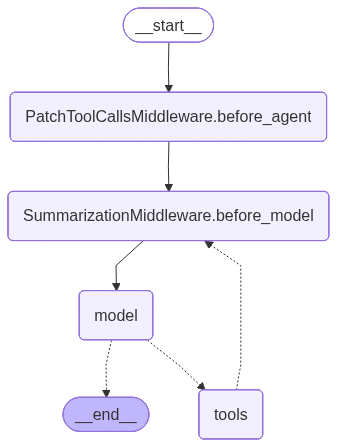

In [14]:
from datetime import datetime
from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from deepagents import create_deep_agent

# Model 
model = init_chat_model(model="anthropic:claude-sonnet-4-5-20250929", temperature=0.0)

# Create the agent
agent = create_deep_agent(
      model=model,
      tools=[tavily_search, think_tool], 
      system_prompt=INSTRUCTIONS,
      subagents=[research_sub_agent],
  )
  
# Show the agent
display(Image(agent.get_graph().draw_mermaid_png()))

In [15]:
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "research context engineering approaches used to build AI agents",
            }
        ],
    }, 
)

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ research context engineering approaches used to build AI agents                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll help you research context engineering approaches used to build AI agents. Let me start by saving your      │
│ request and planning the research.                                                                              │
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "file_path": "/research_request.md",                                                                          │
│   "content": "# Research Request\n\nResearch context engineering approaches used to build AI agents\n\n##       │
│ Date\n2024-01-XX\n\n## Objective\nInvestigate and document the various context engineering approaches,          │
│ techniques, and methodologies used in building AI agents.\n"                                                    │
│ }                                                                                                               │
│    ID: toolu_018SyxbFkLo785AzWmdTiMVo                                                                           │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research context engineering fundamentals and core approaches for AI agents",                 │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research specific techniques and implementation methods",                                     │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Write comprehensive final report to /final_report.md",                                        │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Verify report addresses all aspects of the original request",                                 │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01RYfv2cZLJEss9hww2HEjbR                    

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file /research_request.md                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research context engineering fundamentals and core approaches for AI         │
│ agents', 'status': 'in_progress'}, {'content': 'Research specific techniques and implementation methods',       │
│ 'status': 'pending'}, {'content': 'Write comprehensive final report to /final_report.md', 'status': 'pending'}, │
│ {'content': 'Verify report addresses all aspects of the original request', 'status': 'pending'}]                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Now let me delegate the research to specialized sub-agents to gather comprehensive information about context    │
│ engineering approaches for AI agents.                                                                           │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "subagent_type": "research-agent",                                                                            │
│   "description": "Research context engineering fundamentals and core approaches for AI agents.\n\nYour task is  │
│ to conduct comprehensive research on context engineering approaches used to build AI agents. Focus on:\n\n1.    │
│ What is context engineering in the context of AI agents?\n2. Why is context engineering important for AI        │
│ agents?\n3. Core approaches and methodologies (e.g., prompt engineering, context windows, memory management,    │
│ retrieval-augmented generation)\n4. Key techniques used in practice\n5. Best practices and design               │
│ patterns\n\nUse web searches to find authoritative sources, technical articles, research papers, and industry   │
│ implementations. Gather specific examples and concrete techniques.\n\nReturn a detailed report with:\n- Clear   │
│ explanations of context engineering concepts\n- Specific approaches and techniques with descriptions\n-         │
│ Real-world examples and use cases\n- All sources cited with URLs\n\nAim for 3-5 high-quality sources that cover │
│ different aspects of context engineering for AI agents."                                                        │
│ }                                                                                                               │
│    ID: toolu_01Kx17Te2k6xNyQ4mMNE1Ap8                                                                           │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "subagent_type": "research-agent",                                                                            │
│   "description": "Research advanced context engineering techniques and implementation strategies for AI         │
│ agents.\n\nYour task is to research specific implementation techniques and advanced strategies for context      │
│ engineering in AI agents. Focus on:\n\n1. Context window management and optimization\n2. Long-term memory and   │
│ state management approaches\n3. Context compression and summarization techniques\n4. Multi-turn conversation    │
│ context handling\n5. Tool use and function calling context patterns\n6. Context injection and retrieval         │
│ strategies\n\nUse web searches to find technical documentation, implementation guides, case studies, and        │
│ practical examples from AI companies and frameworks.\n\nReturn a detailed report with:\n- Specific              │
│ implementation techniques with explanations\n- Code patterns or architectural approaches where available\n-     │
│ Trade-offs and considerations for different approaches\n- All sources cited with URLs\n\nAim for 3-5            │
│ high-quality sources focused on practical implementation."                                                      │
│ }                                                                                                               │
│    ID: toolu_01FY49z5xRZZcS6Tk78kZdJY                    

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Now I'll compile a comprehensive report on context engineering fundamentals and core approaches for AI agents   │
│ based on my research findings.                                                                                  │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ # Context Engineering for AI Agents: Comprehensive Research Report                                              │
│                                                                                                                 │
│ ## Executive Summary                                                                                            │
│                                                                                                                 │
│ Context engineering has emerged as a critical discipline in AI agent development, representing a fundamental    │
│ shift from simple prompt engineering to sophisticated system architecture. As Andrej Karpathy describes it,     │
│ context engineering is "the delicate art and science of filling the context window with just the right          │
│ information for the next step" [1]. This report explores the fundamentals, core approaches, key techniques, and │
│ best practices for building effective AI agents through strategic context management.                           │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ ## 1. What is Context Engineering?                                                                              │
│                                                                                                                 │
│ ### Definition and Evolution                                                                                    │
│                                                                                                                 │
│ Context engineering is the discipline of strategically managing, curating, and controlling the information      │
│ provided to large language models (LLMs) [1][2]. It represents an evolution from **prompt engineering** (which  │
│ focuses on crafting instructions) to **context engineering** (which focuses on architecting the entire          │
│ information pipeline before the LLM call).                                                                      │
│                                                                                                                 │
│ While prompt engineering concentrated on writing clever, concise instructions for simple tasks, context         │
│ engineering treats the entire pipeline as engineerable infrastructure [1]. This includes:                       │
│                                                                                                                 │
│ - **Dynamic information gathering**: RAG systems, API calls, database queries                                   │
│ - **Memory management**: Short-term conversation state and long-term knowledge                                  │
│ - **Tool coordination**: Making external functions available when needed                                        │
│ - **Output structuring**: Defining schemas and formats for consistent results                                   │
│                                                        

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ # Advanced Context Engineering Techniques for AI Agents: Implementation Guide                                   │
│                                                                                                                 │
│ ## Executive Summary                                                                                            │
│                                                                                                                 │
│ Context engineering has emerged as a critical discipline for building production-grade AI agents. As LLMs have  │
│ fixed context windows and suffer from performance degradation with long contexts ("context rot"), strategic     │
│ management of what information reaches the model determines system reliability, cost-efficiency, and accuracy.  │
│ This report synthesizes advanced implementation techniques, architectural patterns, and practical strategies    │
│ from leading AI frameworks and production systems.                                                              │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ ## 1. Context Window Management and Optimization                                                                │
│                                                                                                                 │
│ ### 1.1 Understanding Context Limitations                                                                       │
│                                                                                                                 │
│ Modern LLMs advertise large context windows (up to 1 million tokens), but research shows that **effective       │
│ performance occurs within much smaller windows** - typically the first 50,000-100,000 tokens [2]. Beyond this   │
│ threshold, models experience:                                                                                   │
│                                                                                                                 │
│ - **Context rot**: Degraded accuracy and instruction-following capability                                       │
│ - **Lost in the middle phenomenon**: Information buried mid-context gets overlooked                             │
│ - **Increased latency**: Processing 500,000 tokens takes significantly longer than 5,000 tokens                 │
│ - **Higher costs**: Every token incurs inference costs that compound with repeated processing                   │
│                                                                                                                 │
│ ### 1.2 Conservative Context Management Strategy                                                                │
│                                                                                                                 │
│ **Implementation Approach:**                                                                                    │
│                                                                                                                 │
│ 1. **Set aggressive thresholds**: Trigger context management at 40-60% of maximum window, not 80-90% [2]        │
│ 2. **Start fresh frequently**: Reset context after completing major tasks rather than accumulating indefinitely │
│ 3. **Strategic positioning**: Place critical instructions at the beginning and end of prompts where models pay  │
│ most attention [2]                                                                                              │
│ 4. **Query-aware contextualization**: Dynamically adjus

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research context engineering fundamentals and core approaches for AI agents",                 │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research specific techniques and implementation methods",                                     │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Write comprehensive final report to /final_report.md",                                        │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Verify report addresses all aspects of the original request",                                 │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01PLHiBjqThtMiawx2MA31Cb                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research context engineering fundamentals and core approaches for AI         │
│ agents', 'status': 'completed'}, {'content': 'Research specific techniques and implementation methods',         │
│ 'status': 'completed'}, {'content': 'Write comprehensive final report to /final_report.md', 'status':           │
│ 'in_progress'}, {'content': 'Verify report addresses all aspects of the original request', 'status':            │
│ 'pending'}]                                                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Now let me compile the comprehensive research into a final report.                                              │
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "file_path": "/final_report.md",                                                                              │
│   "content": "# Context Engineering Approaches for Building AI Agents\n\n## Overview\n\nContext engineering has │
│ emerged as a critical discipline in AI agent development, representing the strategic management, curation, and  │
│ control of information provided to large language models (LLMs). As Andrej Karpathy describes it, context       │
│ engineering is \"the delicate art and science of filling the context window with just the right information for │
│ the next step\" [1]. This discipline has evolved from simple prompt engineering to sophisticated system         │
│ architecture that determines whether AI agents succeed or fail in production environments.\n\nContext           │
│ engineering directly impacts three fundamental aspects of AI systems: performance and reliability, cost         │
│ efficiency, and user experience [1][2]. Research shows that models perform optimally only in the first          │
│ 50,000-100,000 tokens, even with million-token context windows, making strategic context management essential   │
│ rather than optional [2]. As one researcher noted, \"Most agent failures are context failures\" - the system    │
│ didn't provide adequate information for success [1].\n\n## What is Context Engineering?\n\nContext engineering  │
│ is the discipline of strategically managing, curating, and controlling the information provided to large        │
│ language models [1][2]. It represents an evolution from prompt engineering, which focuses on crafting           │
│ instructions, to context engineering, which focuses on architecting the entire information pipeline before the  │
│ LLM call.\n\nWhile prompt engineering concentrated on writing clever, concise instructions for simple tasks,    │
│ context engineering treats the entire pipeline as engineerable infrastructure [1]. This includes dynamic        │
│ information gathering through RAG systems and API calls, memory management for both short-term conversation     │
│ state and long-term knowledge, tool coordination to make external functions available when needed, and output   │
│ structuring to define schemas and formats for consistent results.\n\nEarly AI development relied heavily on     │
│ prompting methods like chain-of-thought, ReAct, and self-consistency for complex tasks [1]. However, as         │
│ applications evolved into AI agents with multi-step reasoning, long-running conversations, and dynamic          │
│ information retrieval, these approaches hit significant limitations. Context engineering emerged as the         │
│ solution to handle multi-step reasoning requiring tool use, long-running conversations with memory, dynamic     │
│ information retrieval from databases, and coordination between multiple AI systems.\n\n## Why Context           │
│ Engineering Matters\n\nContext engineering has become essential because poor context management creates         │
│ \"context rot\" where model quality degrades well before hitting technical token limits [2]. Models experience  │
│ performance degradation, increased latency, and higher costs as context windows fill up. Processing 500,000     │
│ tokens takes significantly longer than 5,000 tokens, and every token sent to an LLM incurs inference costs that │
│ compound with repeated processing.\n\nProduction systems

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file /final_report.md                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research context engineering fundamentals and core approaches for AI agents",                 │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research specific techniques and implementation methods",                                     │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Write comprehensive final report to /final_report.md",                                        │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Verify report addresses all aspects of the original request",                                 │
│       "status": "in_progress"                                                                                   │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01Qg991pm9a4gYDXFrxvrcdU                                                                           │
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "/research_request.md"                                                                           │
│ }                                                                                                               │
│    ID: toolu_01XzjrBU8A2dSKxQvLe59Dhi                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research context engineering fundamentals and core approaches for AI         │
│ agents', 'status': 'completed'}, {'content': 'Research specific techniques and implementation methods',         │
│ 'status': 'completed'}, {'content': 'Write comprehensive final report to /final_report.md', 'status':           │
│ 'completed'}, {'content': 'Verify report addresses all aspects of the original request', 'status':              │
│ 'in_progress'}]                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│      1  # Research Request                                                                                      │
│      2                                                                                                          │
│      3  Research context engineering approaches used to build AI agents                                         │
│      4                                                                                                          │
│      5  ## Date                                                                                                 │
│      6  2024-01-XX                                                                                              │
│      7                                                                                                          │
│      8  ## Objective                                                                                            │
│      9  Investigate and document the various context engineering approaches, techniques, and methodologies used │
│ in building AI agents.                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research context engineering fundamentals and core approaches for AI agents",                 │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research specific techniques and implementation methods",                                     │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Write comprehensive final report to /final_report.md",                                        │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Verify report addresses all aspects of the original request",                                 │
│       "status": "completed"                                                                                     │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_019isL1uqbXubzS6xQqiXhNU                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research context engineering fundamentals and core approaches for AI         │
│ agents', 'status': 'completed'}, {'content': 'Research specific techniques and implementation methods',         │
│ 'status': 'completed'}, {'content': 'Write comprehensive final report to /final_report.md', 'status':           │
│ 'completed'}, {'content': 'Verify report addresses all aspects of the original request', 'status':              │
│ 'completed'}]                                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Perfect! I've completed comprehensive research on context engineering approaches used to build AI agents.       │
│ Here's what I found:                                                                                            │
│                                                                                                                 │
│ ## Summary                                                                                                      │
│                                                                                                                 │
│ Context engineering has emerged as **the critical discipline** for building production-grade AI agents. It's    │
│ evolved from simple prompt engineering to sophisticated system architecture that manages the entire information │
│ pipeline before LLM calls.                                                                                      │
│                                                                                                                 │
│ ### Key Findings:                                                                                               │
│                                                                                                                 │
│ **What is Context Engineering?**                                                                                │
│ - Strategic management of information provided to LLMs                                                          │
│ - Encompasses memory management, retrieval strategies, compression, and structural isolation                    │
│ - Determines whether AI agents succeed or fail in production                                                    │
│                                                                                                                 │
│ **Four Core Strategies:**                                                                                       │
│ 1. **Writing Context** - Saving information outside context windows (scratchpads, long-term memory)             │
│ 2. **Selecting Context** - Intelligent retrieval of only relevant information (RAG, agentic RAG)                │
│ 3. **Compressing Context** - Summarization and pruning to reduce token usage                                    │
│ 4. **Isolating Context** - Multi-agent architectures and sandboxes for separation of concerns                   │
│                                                                                                                 │
│ **Six Essential Techniques:**                                                                                   │
│ 1. **Pruning** - Removing old/irrelevant information                                                            │
│ 2. **Summarization** - Compressing while preserving meaning                                                     │
│ 3. **Offloading** - Moving large data to external storage                                                       │
│ 4. **Atomic Tools** - Single-responsibility tools to reduce prompt bloat                                        │
│ 5. **Context Isolation** - Sub-agents for complex workflows                                                     │
│ 6. **Conservative Management** - Triggering interventions at 40-60% capacity, not 80-90%                        │
│                                                                                                                 │
│ **Performance Impact:**                                                                                         │
│ - 10x reduction in token usage                                                                                  │
│ - 50-70% latency improvements                                                                                   │
│ - Similar cost reductions                              

In [31]:
from deepagents.backends.utils import file_data_to_string

# Convert a specific file to string
file_content = file_data_to_string(result["files"]['/final_report.md'])
show_prompt(file_content) 

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  # Context Engineering Approaches for Building AI Agents                                                        │
│                                                                                                                 │
│  ## Overview                                                                                                    │
│                                                                                                                 │
│  Context engineering has emerged as a critical discipline in AI agent development, representing the strategic   │
│  management, curation, and control of information provided to large language models (LLMs). As Andrej Karpathy  │
│  describes it, context engineering is "the delicate art and science of filling the context window with just     │
│  the right information for the next step" [1]. This discipline has evolved from simple prompt engineering to    │
│  sophisticated system architecture that determines whether AI agents succeed or fail in production              │
│  environments.                                                                                                  │
│                                                                                                                 │
│  Context engineering directly impacts three fundamental aspects of AI systems: performance and reliability,     │
│  cost efficiency, and user experience [1][2]. Research shows that models perform optimally only in the first    │
│  50,000-100,000 tokens, even with million-token context windows, making strategic context management essential  │
│  rather than optional [2]. As one researcher noted, "Most agent failures are context failures" - the system     │
│  didn't provide adequate information for success [1].                                                           │
│                                                                                                                 │
│  ## What is Context Engineering?                                                                                │
│                                                                                                                 │
│  Context engineering is the discipline of strategically managing, curating, and controlling the information     │
│  provided to large language models [1][2]. It represents an evolution from prompt engineering, which focuses    │
│  on crafting instructions, to context engineering, which focuses on architecting the entire information         │
│  pipeline before the LLM call.                                                                                  │
│                                                                                                                 │
│  While prompt engineering concentrated on writing clever, concise instructions for simple tasks, context        │
│  engineering treats the entire pipeline as engineerable infrastructure [1]. This includes dynamic information   │
│  gathering through RAG systems and API calls, memory management for both short-term conversation state and      │
│  long-term knowledge, tool coordination to make external functions available when needed, and output            │
│  structuring to define schemas and formats for consistent results.                                              │
│                                                                                                                 │
│  Early AI development relied heavily on prompting methods like chain-of-thought, ReAct, and self-consistency    │
│  for complex tasks [1]. However, as applications evolved into AI agents with multi-step reasoning,              │
│  long-running conversations, and dynamic information r

Trace: 

https://smith.langchain.com/public/cd2262de-08b1-4e0d-86d3-f9ed3b957921/r